In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import xregrid as xg
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
basedir = '/data/scratch/takaya/POP_data/Surface_Daily/'

In [3]:
fname = os.path.join(basedir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-07-01.nc')

In [4]:
ds = xr.open_dataset(fname, decode_times=False)
nroll = -1100
mask = ds.KMT>1
SST = ds.SST.where(mask).roll(nlon=nroll)
lat = ds.TLAT.where(mask).roll(nlon=nroll)
lon = ds.TLONG.where(mask).roll(nlon=nroll)

In [5]:
SST_stacked = SST.reset_coords(['ULONG', 'ULAT'], drop=True).stack(points=('nlat', 'nlon')).copy()
lat_stacked = lat.reset_coords(['ULONG', 'ULAT'], drop=True).stack(points=('nlat', 'nlon')).copy()
lon_stacked = lon.reset_coords(['ULONG', 'ULAT'], drop=True).stack(points=('nlat', 'nlon')).copy()


Nt = SST_stacked.shape[0]
for t in range(Nt):
    if t == 0:
        SST_comp = np.empty((Nt, 
                            np.ma.masked_invalid(SST_stacked[t].values).compressed().shape[0]))
    SST_comp[t] = np.ma.masked_invalid(SST_stacked[t].values).compressed()
lat_comp = np.ma.masked_invalid(lat_stacked.values).compressed()
lon_comp = np.ma.masked_invalid(lon_stacked.values).compressed()

latlon = list(zip(lat_comp.ravel(), lon_comp.ravel()))
latlon_array = np.empty(len(latlon), dtype=object)
for i in range(len(latlon)):
    latlon_array[i] = latlon[i]


SST_comp_xray = xr.DataArray(SST_comp, dims=['day', 'latlon'], 
                             coords={'day': range(Nt), 'latlon': latlon_array}).to_dataset(name='SST')

# Test domain

In [7]:
x = np.arange(151., 197., .25)
y = np.arange(31., 56., .25)
xx, yy = np.meshgrid(x, y)

In [10]:
args = ['latlon', 'day', 'SST', 'lat', 'lon']
SST_regrid = xg.regrid_var(SST_comp_xray, xx, yy, True, False, *args)

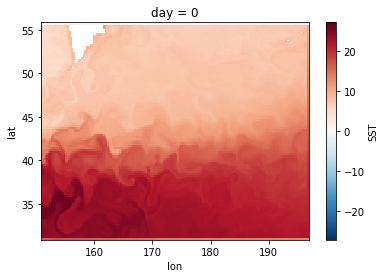

In [11]:
SST_regrid.SST[0].plot()

In [17]:
%lprun -f xg.regrid_var xg.regrid_var(SST_comp_xray, xx, yy, True, True, *args)

In [ ]:
args = ['latlon', 'day', 'SST', 'lat', 'lon']
%load_ext line_profiler
%lprun -f xg.regrid_var xg.regrid_var(SST_comp_xray, xx, yy, True, False, *args)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Use xarray.DataSet.unstack to unstack the data

In [ ]:
x = np.arange(0., 360.25, .25)
y = np.arange(-61.75, 62., .25)
xx, yy = np.meshgrid(x, y)

In [ ]:
args = ['latlon', 'day', 'SST', 'lat', 'lon']
SST_regrid = xg.regrid_var(SST_comp_xray, xx, yy, True, True, *args)

In [17]:
# swotdir = '/swot/SUM05/takaya/POP_data/'
# savename = os.path.join(swotdir, 'SST_025deg_orthogonalgrid.0046-07.nc')
# print savename
# SST_regrid.to_netcdf(savename, mode='w', format='NETCDF4')

/swot/SUM05/takaya/POP_data/SST_025deg_orthogonalgrid.0046-01.nc


# Use numpy.reshape to unstack the data

In [ ]:
args = ['latlon', 'day', 'SST', 'lat', 'lon']
SST_regrid = xg.regrid_var(SST_comp_xray, xx, yy, True, False, *args)

In [ ]:
SST_regrid.SST[20].plot()

In [ ]:
swotdir = '/swot/SUM05/takaya/POP_data/'
savename = os.path.join(swotdir, 'SST_025deg_orthogonalgrid.0046-07.nc')
print savename
SST_regrid.to_netcdf(savename, mode='w', format='NETCDF4')